In [45]:
import torch
import os
import numpy as np
import pandas as pd
from utils import modify_metadata, TARGETS
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [7]:
scaler = 'constant'
logsigs_or_sigs = 'logsigs'

In [10]:
TRAIN_METADATA_DIR = "../../data/train.csv"
TRAIN_SIGNATURES_DIR = "../../data/train_signatures/"
TRAIN_SIGNATURES_FILE = f"{TRAIN_SIGNATURES_DIR}all_{logsigs_or_sigs}_lvl_5_scaler_{scaler}.npy"

In [11]:
train_metadata = pd.read_csv(TRAIN_METADATA_DIR)
train_metadata = modify_metadata(train_metadata)
signature_features = np.load(TRAIN_SIGNATURES_FILE)

In [12]:
train_metadata

,eeg_id,spectrogram_id,eeg_offset_seconds,spec_offset_seconds,patient_id,target,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,9.0,9.0,20654,Other,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,1552638400,18.0,18.0,20230,LPD,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,14960202,12.0,1020.0,5955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,618728447,0.0,908.0,38549,GPD,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,52296320,0.0,0.0,40955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,1188113564,0.0,0.0,16610,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17085,4293843368,1549502620,0.0,0.0,15065,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17086,4294455489,2105480289,0.0,0.0,56,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
17087,4294858825,657299228,6.0,6.0,4312,Other,0.0,0.000000,0.00,0.000000,0.066667,0.933333


In [64]:
class TrainDataset(Dataset):
    """Assumes precomputed signatures are available"""
    def __init__(self, metadata, features):
        self.metadata = metadata
        self.features = self.preprocess_features(features)
        self.labels = torch.Tensor(metadata[TARGETS].values)

    def preprocess_features(self, features):
        features = features.reshape(features.shape[0], -1)
        # normalize features
        features = (features - np.mean(features, axis=0)) / (np.std(features, axis=0) + 1e-6)
        # clip 5 stds
        features = np.clip(features, -5, 5)

        return torch.Tensor(features)
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        sample = self.features[idx]
        label = self.labels[idx]
        return sample, label

In [65]:
dataset = TrainDataset(train_metadata, signature_features)

In [66]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [67]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

(array([4.600e+01, 4.000e+00, 5.000e+00, 7.000e+00, 6.000e+00, 6.000e+00,
        4.000e+00, 1.600e+01, 5.600e+01, 1.600e+01, 1.600e+01, 8.000e+00,
        8.000e+00, 1.200e+01, 6.000e+00, 1.000e+01, 1.200e+01, 7.000e+00,
        1.200e+01, 1.100e+01, 1.200e+01, 1.200e+01, 2.600e+01, 1.600e+01,
        1.900e+01, 2.200e+01, 1.500e+01, 2.000e+01, 2.200e+01, 1.800e+01,
        2.700e+01, 2.900e+01, 4.100e+01, 6.400e+01, 4.500e+01, 5.600e+01,
        4.300e+01, 8.000e+01, 8.500e+01, 9.700e+01, 1.250e+02, 1.530e+02,
        1.800e+02, 2.480e+02, 3.640e+02, 5.720e+02, 7.300e+02, 1.075e+03,
        1.601e+03, 2.563e+03, 2.417e+03, 1.626e+03, 1.064e+03, 7.240e+02,
        4.750e+02, 3.570e+02, 2.540e+02, 2.120e+02, 1.570e+02, 1.490e+02,
        1.050e+02, 9.100e+01, 6.600e+01, 5.100e+01, 6.600e+01, 3.800e+01,
        5.000e+01, 3.500e+01, 3.200e+01, 2.800e+01, 2.300e+01, 2.300e+01,
        2.600e+01, 2.300e+01, 1.500e+01, 2.200e+01, 1.000e+01, 2.400e+01,
        1.300e+01, 1.800e+01, 1.900e+0

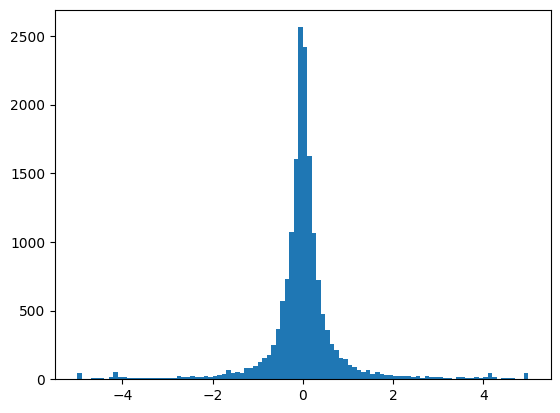

In [68]:
plt.hist(dataset.features[:, 1], bins=100)